In [1]:
import torch
import bgflow as bg
from tqdm.auto import tqdm

In [2]:
unbiased_target = bg.DoubleWellEnergy(dim=2)
N_UMBRELLAS = 10

class UmbrellaEnergy(bg.Energy):
    def __init__(
            self,
            event_shapes,
            centers,
            force_constants,
            # by default, take x as the reaction coordinate
            reaction_coordinate=lambda xs: xs[...,0]
    ):
        super().__init__(event_shapes)
        self.centers = centers
        self.force_constants = force_constants
        self.reaction_coordinate = reaction_coordinate
    
    def _energy(self, *xs):
        rc = self.reaction_coordinate(*xs)
        umbrella = (rc - self.centers)**2
        bias = 0.5 * self.force_constants * umbrella
        return bias[..., None]
    

class BiasedEnergy(bg.Energy):
    def __init__(self, target, bias):
        super().__init__(target.event_shapes)
        self.target = target
        self.bias = bias
        
    def _energy(self, *xs):
        return self.target.energy(*xs) + self.bias.energy(*xs)

In [3]:
bias_energy=UmbrellaEnergy(
    unbiased_target.event_shapes, 
    centers=torch.linspace(-2, 2, N_UMBRELLAS),
    force_constants=100.*torch.ones(N_UMBRELLAS)
)

biased_target = BiasedEnergy(
    target=unbiased_target,
    bias=bias_energy
)

# test energy call
biased_target.energy(torch.randn(N_UMBRELLAS, 2)).shape

torch.Size([10, 1])

In [4]:
mcmc_step = bg.MCMCStep(
    biased_target,
    proposal=bg.GaussianProposal(noise_std=0.1),
    target_temperatures=1.0,
)

mcsampler = bg.IterativeSampler(
    bg.SamplerState(torch.randn(N_UMBRELLAS, 2)),
    [mcmc_step],
    stride=20,
    n_burnin=10,
    progress_bar=tqdm,
    # we return energies and samples so that we can reweight later
    extract_sample_hook=lambda state:state.samples + [state.energies]
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
*samples, energies = mcsampler.sample_to_cpu(5000, batch_size=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

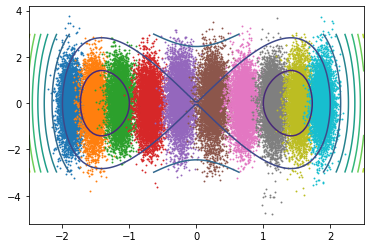

In [6]:
from matplotlib import pyplot as plt
from bgflow.utils.types import as_numpy, unpack_tensor_tuple

x = torch.linspace(-2.5,2.5,100)
y = torch.linspace(-3,3,100)
X, Y = torch.meshgrid(x,y)
Z = unbiased_target.energy(torch.stack([X,Y], dim=-1).reshape(-1,2))
plt.contour(as_numpy(X),as_numpy(Y), as_numpy(Z).reshape(100,100))

sampl = as_numpy(unpack_tensor_tuple(samples))
for i in range(N_UMBRELLAS):
    plt.scatter(sampl[:,i,0], sampl[:,i,1], s=0.8)

In [7]:
biases = bias_energy.energy(*samples)
targets = energies - biases

In [8]:
biases.mean(dim=0), targets.mean(dim=0)

(tensor([[1.0512],
         [0.4372],
         [0.5027],
         [0.5722],
         [0.5630],
         [0.5778],
         [0.6000],
         [0.5284],
         [0.4390],
         [1.0712]]),
 tensor([[-1.0325],
         [-3.3150],
         [-3.0325],
         [-1.3220],
         [ 0.2498],
         [ 0.2441],
         [-1.3278],
         [-2.9948],
         [-3.3025],
         [-0.9976]]))